In [1]:
import torch
import os
import numpy as np
from torchvision import datasets, transforms
from torchvision.utils import save_image
from typing import Tuple, List, Dict, Union, Any, cast, Literal

from pytorch.dataloader.dl import get_dataloader, FlareEvent
from pytorch.config import SolarConfig
from datetime import datetime, timedelta
from torch.utils.data import DataLoader
import logging

# from mnist.model import VAEMNIST
from pytorch.models.model_d6_layer4_1 import ModelDepth6Layer4
from pytorch.models.model_d6_layer4_1_dropout import ModelDepth6Layer4Dropout, load_from_version


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

2024-05-31 16:15:06,789 INFO [38565] - Cache path: /home/andries/projects/mai-thesis/src/common/../../data/disk-cache/source-raw


In [2]:
data_path = os.path.join('../../', 'data')
image_path = os.path.join(data_path, 'flare_images_preprocessed')
pl_logs = os.path.join(data_path, 'lightning_logs')
print("data_path: ", data_path)
print("pl_logs: ", pl_logs)

# memory leak fix
num_workers = 0

config: SolarConfig = SolarConfig(
    local_data_path=data_path,
    image_data_path=image_path,
    image_dimension=(6, 512, 512),
    channels_name=["source_19"],
    timedimension_max_timedelta=timedelta(hours=16),
    flare_data_file="valid_flares_10h.pickle",
)
dl, dataset = get_dataloader(config, batch_size=16, num_workers=num_workers, shuffle=False, data_only=True)

2024-05-31 16:15:11,963 INFO [38565] - Loading annotations from ../../data
INFO:pytorch.dataloader.dl:Loading annotations from ../../data


data_path:  ../../data
pl_logs:  ../../data/lightning_logs


In [3]:
# Check your 'data/lightning_logs' directory for the version number and checkpoint file.

version = 0
checkpoint_file = "epoch=2-step=6.ckpt"

model: ModelDepth6Layer4Dropout = load_from_version(pl_logs, dropout=0.0, version=version, checkpoint_file=checkpoint_file)

In [4]:
latent_kl_loss_path = os.path.join(pl_logs, f'version_{version}', 'latent_kl_loss.txt')

# read last 32 lines of the file (32 latent dimensions)
with open(latent_kl_loss_path) as file:
    last_lines = file.readlines()[-32:]
kl_losses = {l.split(",")[2]: float(l.split(",")[3].strip()) for l in last_lines}
kl_losses

{'kl_loss_0': 5.313754081726074e-05,
 'kl_loss_1': 1.1945143342018127e-05,
 'kl_loss_2': 0.00010206550359725952,
 'kl_loss_3': 0.00010570511221885681,
 'kl_loss_4': 9.598582983016968e-05,
 'kl_loss_5': 1.8442049622535706e-05,
 'kl_loss_6': 3.189407289028168e-05,
 'kl_loss_7': 3.6932528018951416e-05,
 'kl_loss_8': 0.00011359527707099915,
 'kl_loss_9': 1.1974945664405823e-05,
 'kl_loss_10': 8.22991132736206e-05,
 'kl_loss_11': 3.0878931283950806e-05,
 'kl_loss_12': 8.50427895784378e-05,
 'kl_loss_13': 0.00010774843394756317,
 'kl_loss_14': 7.165968418121338e-05,
 'kl_loss_15': 2.954527735710144e-05,
 'kl_loss_16': 2.4870038032531738e-05,
 'kl_loss_17': 9.972788393497467e-05,
 'kl_loss_18': 0.00012240372598171234,
 'kl_loss_19': 9.66731458902359e-05,
 'kl_loss_20': 3.051571547985077e-05,
 'kl_loss_21': 0.00011152029037475586,
 'kl_loss_22': 5.540624260902405e-05,
 'kl_loss_23': 2.522207796573639e-05,
 'kl_loss_24': 3.7321820855140686e-05,
 'kl_loss_25': 3.987550735473633e-05,
 'kl_loss_26

In [5]:
from tqdm import tqdm

def get_average_latent_activation(m, data_loader: DataLoader, latent_dim: int = 32, device: Literal["cpu", "cuda"] = "cuda"):
    """Returns tensor of shape [latent_dim, 1, 6, 512, 512]"""
    average_z = torch.zeros((latent_dim, 1, 6, 512, 512), device=device)
    count = 0

    m.to(device)

    for data in tqdm(data_loader):
        # data shape (16, 1, 6, 512, 512) = (batch_size, channels, time, height, width)
        # print(data.shape)
        data = data.to(device)
        batch_size = data.size(0)

        with torch.inference_mode():
            recon, mu, log_var = m(data)
        
        std = torch.exp(0.5 * log_var)
        z = mu + std # shape [16, 32] = (batch_size, latent_dim)
        assert latent_dim == z.size(1), f"Expected latent_dim {latent_dim} but got {z.size(1)}"

        for b in range(batch_size):
            z_batch_item = z[b] # shape [32]
            img = data[b] # shape [1, 6, 512, 512]
            for z_index in range(latent_dim):
                z_val = z_batch_item[z_index]
                average_z[z_index] += z_val * img
            
        count += batch_size

    average_z /= count

    return average_z

average_tensor = get_average_latent_activation(model, dl)
print(average_tensor.shape)

number of results 30
number of filtered results #1 28
number of filtered results #2 28
number of filtered results #3 28


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

torch.Size([32, 1, 6, 512, 512])


In [6]:
# Check if file exists
file_path = "average_tensor.pt"
if not os.path.exists(file_path):
    # Save average_tensor to file
    torch.save(average_tensor, file_path)
    print("Saved average_tensor to", file_path)
else:
    # Load average_tensor from file
    average_tensor = torch.load(file_path)
    print("Loaded average_tensor from", file_path)

print(average_tensor.shape)

Loaded average_tensor from average_tensor.pt
torch.Size([32, 1, 6, 512, 512])


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_model_latent_mean_traversal_grid(model, latent_dim: int, kl_losses: Dict[str, str], z_sample: torch.Tensor):
    assert z_sample.shape == (1, latent_dim), f"Expected shape (1, {latent_dim}) but got {z_sample.shape}"

    # calculate adapted z = mu + std * eps where eps ~ N(0,1)
    # iterate over -3, +3 std
    kl_losses_num = [kl_losses[k] for k in kl_losses]
    sorted_indexes = np.argsort(kl_losses_num)[::-1].tolist()
    sorted_var = [float(kl_losses_num[s]) for s in sorted_indexes]

    # init z
    grid = torch.zeros((latent_dim, 7, 1, 6, 512, 512)) # <latent_dim, x-axis, channels, time, height, width>
    std_space = np.linspace(-3, 3, 7)
    for i, z_index in tqdm(enumerate(sorted_indexes), total=latent_dim):
        for idx, s in enumerate(std_space):
            # z_clone = torch.zeros((1, latent_dim))
            z_clone = z_sample.clone()
            z_clone[0][z_index] = z_clone[0][z_index].item() + s  # shape [1, latent_dim]
            recon_z = model.decode(z_clone).clone()
            grid[i][idx] = recon_z

    # save_image(grid.view(10 * 7, 1, 32, 32), 'mnist/results/beta1_00.png', nrow=7)

    return grid, sorted_indexes, sorted_var

# Plot the grid
sample = dataset[1]
sample = sample.to("cuda")
with torch.inference_mode():
    batch_sample = sample.unsqueeze(0)
    mu, logvar = model.encode(batch_sample)

grid, sorted_indexes, sorted_var = get_model_latent_mean_traversal_grid(model, latent_dim=32, kl_losses=kl_losses, z_sample=mu)

100%|██████████| 32/32 [00:00<00:00, 45.03it/s]


In [8]:
print(grid.shape)
print(grid[0][0].shape)
print(grid[0][0][:].shape)
print(grid[0][0].permute(1, 2, 3, 0).shape)
print(grid[0][0].permute(1, 2, 3, 0)[5].shape)


torch.Size([32, 7, 1, 6, 512, 512])
torch.Size([1, 6, 512, 512])
torch.Size([1, 6, 512, 512])
torch.Size([6, 512, 512, 1])
torch.Size([512, 512, 1])


torch.Size([1, 6, 512, 512])
torch.Size([32, 1, 6, 512, 512])


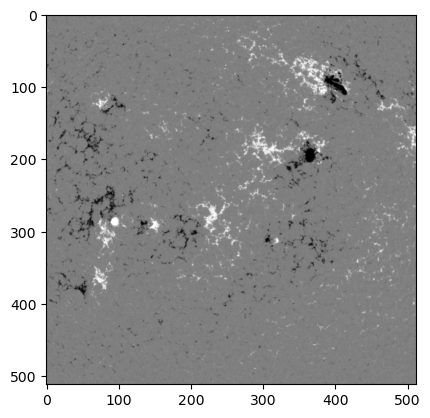

In [18]:
sample = dataset[1]
print(sample.shape)
print(average_tensor.shape)

# plot a sample image
plt.imshow(sample[0][5].cpu().numpy(), cmap='gray')

100%|██████████| 32/32 [00:00<00:00, 124.62it/s]


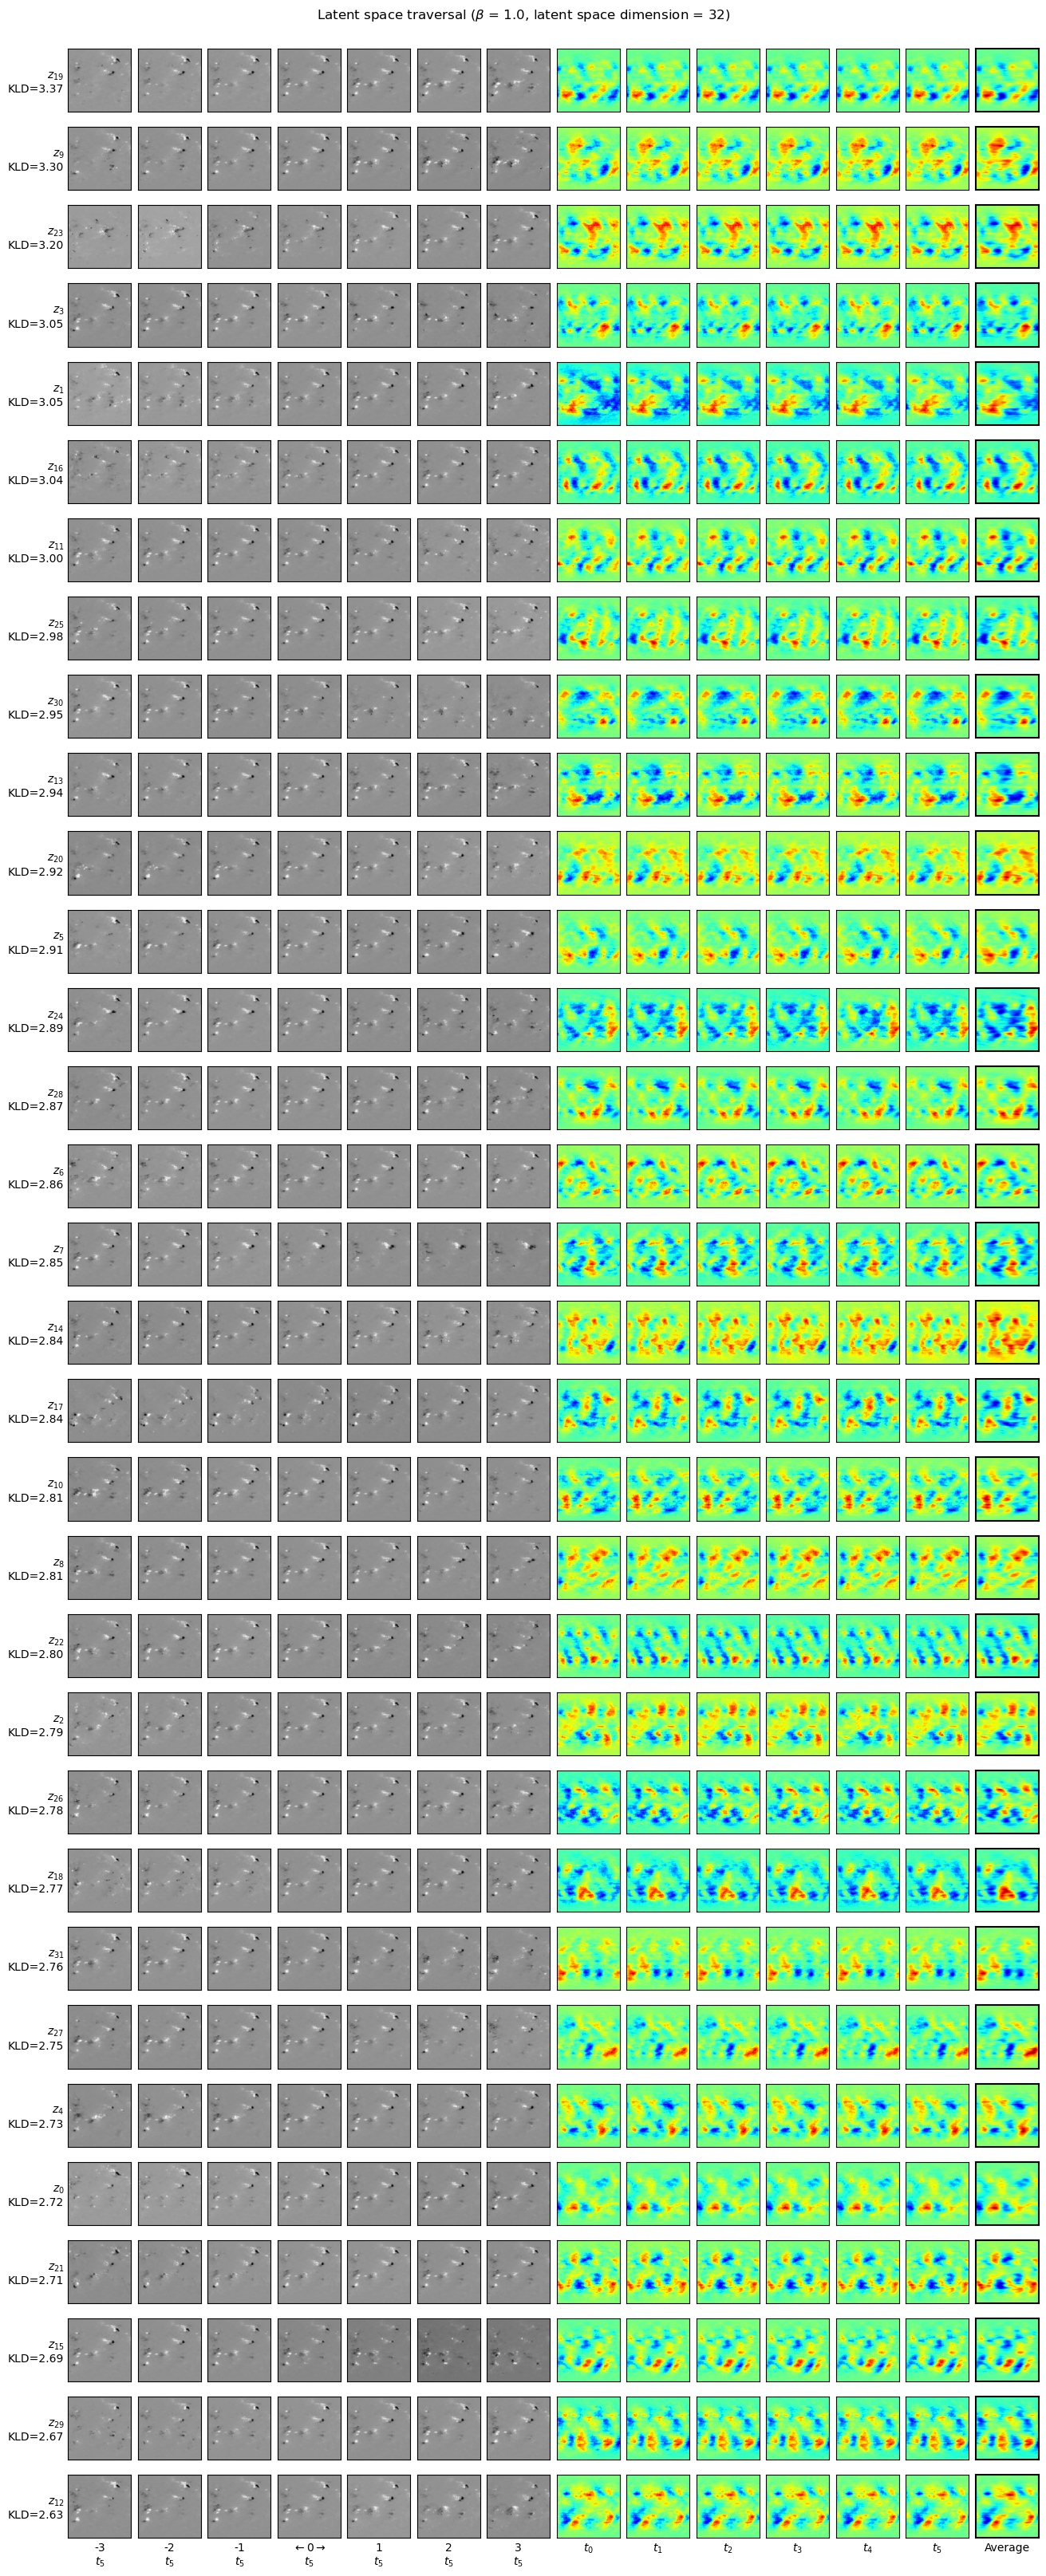

In [10]:
from tqdm import tqdm

def plot_all(grid, average_tensor,  beta: float, plot_time_dimension: int = 5):
    average_tensor = average_tensor.to('cpu') if average_tensor.is_cuda else average_tensor
    # grid = grid.view(32, 7, 1, 6, 512, 512)
    h = grid.shape[0]
    w = grid.shape[1]
    img_height = grid.shape[-1]
    latent_dim = grid.shape[0]

     # Define the labels for the x-ticks
     
    x_ticks_labels = [x for x in [f'-3', '-2', '-1', r'$\leftarrow$0$\rightarrow$', '1', '2', '3']]  # Replace this with your actual labels
    x_ticks_labels = [f"{l}\n$t_{{{plot_time_dimension}}}$" for l in x_ticks_labels]
    y_ticks_labels_1 = [f"$z_{{{x}}}$" for x in sorted_indexes]
    y_ticks_labels_2 = [f"{x:.2f}" for x in sorted_var]
    y_ticks_labels_zip = [j + "\nKLD=" + i for i, j in zip(y_ticks_labels_2, y_ticks_labels_1)]

    extra_width = 6
    extra_width_avg = 1
    fig, ax = plt.subplots(h, w + extra_width + extra_width_avg, figsize=(w+extra_width, h), constrained_layout=True)
    for i in tqdm(range(h)):
        for j in range(w+extra_width):
            if j < w:
                # grid[0][0].permute(1, 2, 3, 0)[<time_dim>] shape equals <512, 512, 1>
                ax[i, j].imshow(grid[i][j].permute(1, 2, 3, 0)[plot_time_dimension].detach().numpy(), cmap='grey')
            
                if i == h -1:
                    ax[i, j].set_xticks([img_height/2])
                    ax[i, j].set_xticklabels([x_ticks_labels[j]], fontsize='medium')
                    ax[i, j].tick_params(axis='x', which='both', length=0)
                else:
                    ax[i, j].get_xaxis().set_visible(False)
                if j == 0:
                    ax[i, j].set_yticks([img_height/2])
                    ax[i, j].set_yticklabels([y_ticks_labels_zip[i]], fontsize='medium')
                    ax[i, j].tick_params(axis='y', which='both', length=0)
                else:
                    ax[i, j].get_yaxis().set_visible(False)

            else:
                idx = sorted_indexes[i]
                time_idx = j - w
                ax[i, j].imshow(average_tensor[idx].squeeze().detach().numpy()[time_idx], cmap='jet')
                ax[i, j].get_yaxis().set_visible(False)

                if i == h - 1:
                    ax[i, j].set_xticks([img_height/2])
                    ax[i, j].set_xticklabels([f"$t_{{{time_idx}}}$"], fontsize='medium')
                    ax[i, j].tick_params(axis='x', which='both', length=0)
                else:
                    ax[i, j].get_xaxis().set_visible(False)

        # plot average of average_tensor for each i
        idx = sorted_indexes[i]
        ax[i, w + extra_width].imshow(
            average_tensor[idx].squeeze().detach().numpy().mean(axis=0), cmap="jet"
        )
        ax[i, w + extra_width].get_yaxis().set_visible(False)
        ax[i, w + extra_width].spines["bottom"].set_linewidth(1.5)
        ax[i, w + extra_width].spines["top"].set_linewidth(1.5)
        ax[i, w + extra_width].spines["right"].set_linewidth(1.5)
        ax[i, w + extra_width].spines["left"].set_linewidth(1.5)

        if i == h - 1:
            ax[i, w + extra_width].set_xticks([img_height / 2])
            ax[i, w + extra_width].set_xticklabels(["Average"], fontsize="medium")
            ax[i, w + extra_width].tick_params(axis="x", which="both", length=0)
        else:
            ax[i, w + extra_width].get_xaxis().set_visible(False)

    fig.suptitle(f"Latent space traversal ($\\beta$ = {beta}, latent space dimension = {latent_dim})",ha='center',va='bottom')
    plt.show()



plot_all(grid, average_tensor, beta=1.0)